The purpose of this notebook is to consider some of the functions of the librosa library and the use of this library in the implementation of [the pitch shifter algorithm](https://www.guitarpitchshifter.com/algorithm.html)

In [184]:
import librosa
import numpy as np
import soundfile
import sys
import scipy.io.wavfile
import matplotlib.pyplot as plt
import wave
import sklearn
import IPython.display as ipd
from sklearn.preprocessing import minmax_scale

In [185]:
data, sr = librosa.load("test_mono.wav")
x = data
T = librosa.get_duration(y=data, sr=sr)
t = np.linspace(0, T, int(T*sr), endpoint=False)

<h4>Signal</h4>

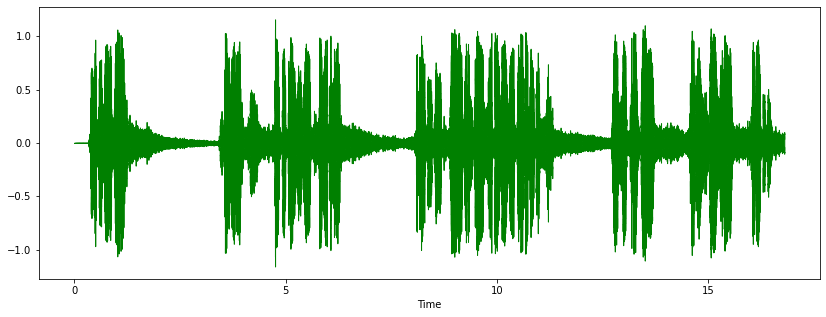

In [186]:
plt.figure(figsize=(14, 5))
librosa.display.waveshow(data, sr=sr, color="green")

<h4>Spectrogram</h4>

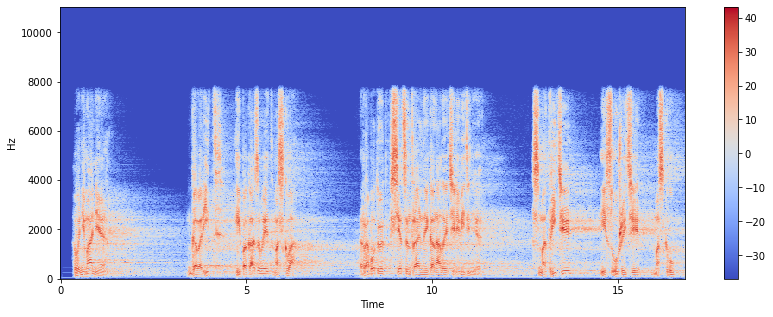

In [187]:
X = librosa.stft(data)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=sr, x_axis="time", y_axis="hz")
plt.colorbar()

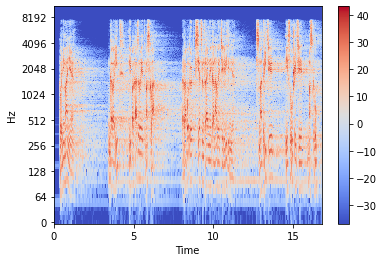

In [188]:
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
plt.colorbar()

<h4>Compute spectral centroid</h4>

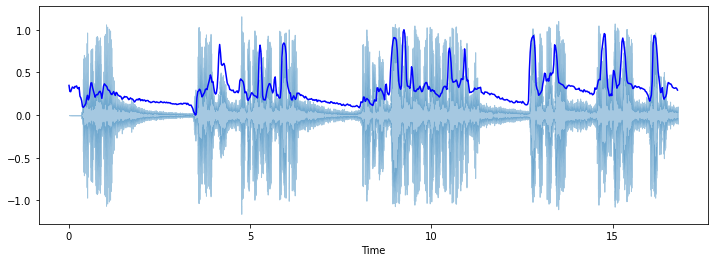

In [189]:
spectral_centroids = librosa.feature.spectral_centroid(y=x, sr=sr)[0]
plt.figure(figsize=(12, 4))

frames = range(len(spectral_centroids))
t = librosa.frames_to_time(frames)
librosa.display.waveshow(x, sr=sr, alpha=0.4)
plt.plot(t, minmax_scale(spectral_centroids, axis=0), color='b')

<h4>Compute spectral rolloff</h4>

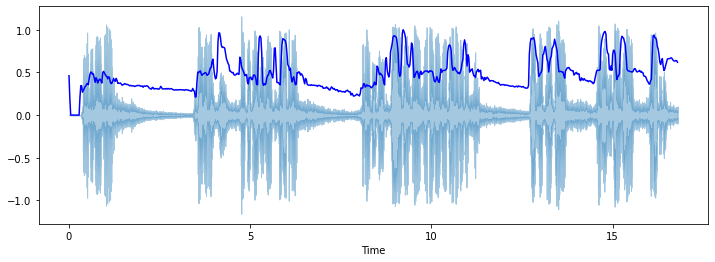

In [190]:
spectral_rolloff = librosa.feature.spectral_rolloff(y=(x + 0.01), sr=sr)[0]
plt.figure(figsize=(12, 4))
librosa.display.waveshow(data, sr=sr, alpha=0.4)
plt.plot(t, minmax_scale(spectral_rolloff, axis=0), color='b')

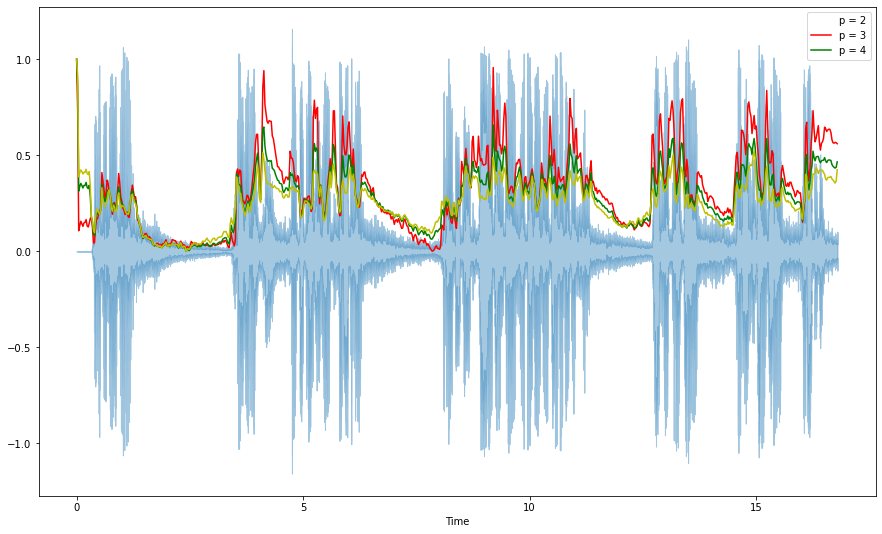

In [191]:
spectral_bandwidth_2 = librosa.feature.spectral_bandwidth(y=(x + 0.01), sr=sr)[0]
spectral_bandwidth_3 = librosa.feature.spectral_bandwidth(y=(x + 0.01), sr=sr, p=3)[0]
spectral_bandwidth_4 = librosa.feature.spectral_bandwidth(y=(x + 0.01), sr=sr, p=4)[0]
plt.figure(figsize=(15,9))

librosa.display.waveshow(x, sr=sr, alpha=0.4)
plt.plot(t, minmax_scale(spectral_bandwidth_2), color='r')
plt.plot(t, minmax_scale(spectral_bandwidth_3), color='g')
plt.plot(t, minmax_scale(spectral_bandwidth_4), color='y')
plt.legend(('p = 2', 'p = 3', 'p = 4'))


<h4>Zero crossing speed</h4>

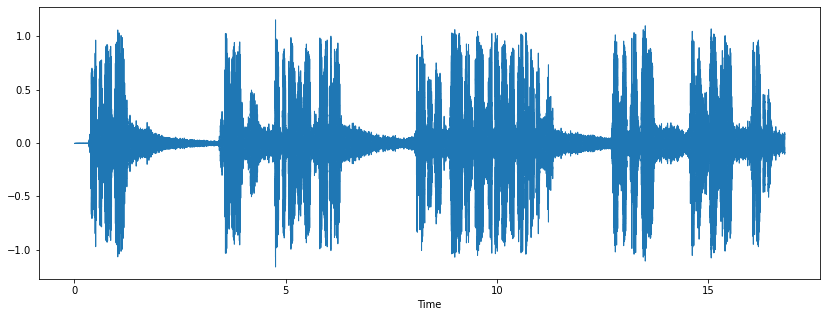

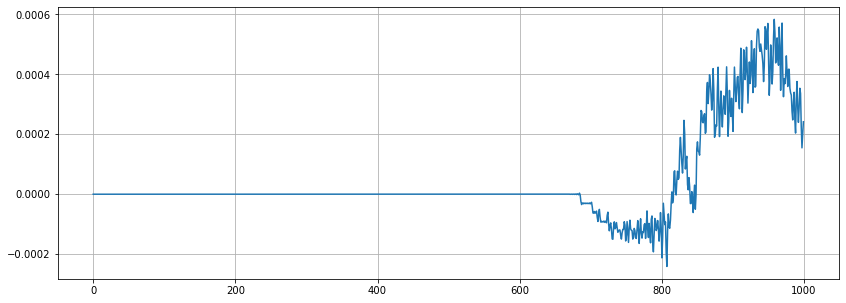

In [192]:
x, sr = librosa.load('test_mono.wav')
plt.figure(figsize=(14, 5))
librosa.display.waveshow(x, sr=sr)
n0 = 0
n1 = 1000
plt.figure(figsize=(14, 5))
plt.plot(x[n0:n1])
plt.grid()

In [193]:
zero_crossing = librosa.zero_crossings(x[n0:n1], pad=False)
print("number of zero crossings: ",sum(zero_crossing))

number of zero crossings:  96


(20, 724)


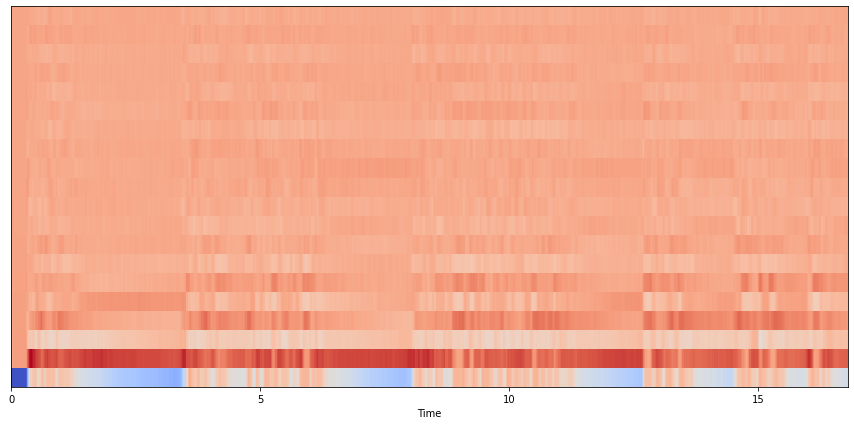

In [194]:
mfccs = librosa.feature.mfcc(y=x, sr=sr)
print(mfccs.shape)
plt.figure(figsize=(15, 7))
librosa.display.specshow(mfccs, sr=sr, x_axis='time')

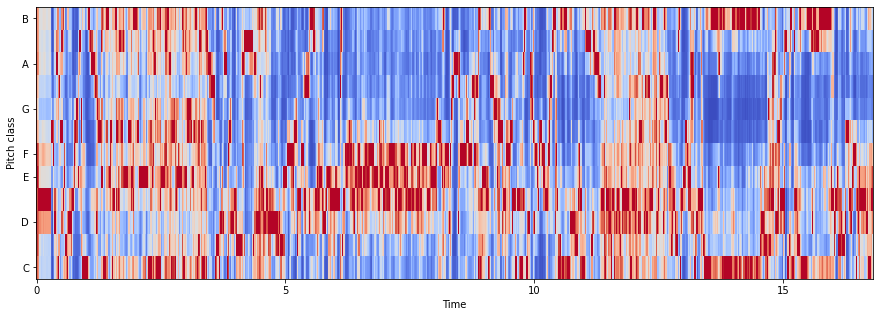

In [195]:
chromagram = librosa.feature.chroma_stft(y=x, sr=sr, hop_length=512)
plt.figure(figsize=(15, 5))
librosa.display.specshow(chromagram, x_axis='time', y_axis='chroma', hop_length=512, cmap='coolwarm')

<h4>Sound stretching and compression</h3>

Algorithm "pitch Vocoder" will be take from article: 

In [196]:
def pitch_shift(data, ratio, window_length=2048, hop_length=512):
    frames = librosa.core.spectrum.util.frame(
        np.pad(data, int(window_length // 2), mode='reflect'),
        frame_length=window_length, hop_length=int(window_length/4)
        )

    fft_weights = np.hamming(window_length)
    
    stft = np.fft.rfft(frames * fft_weights[:, None], axis=0) 
    bins_phase = np.linspace(0, np.pi * window_length / 4, stft.shape[0]) #phase frequencies
    phase_shift = np.angle(stft[:, 0]) #phase difference between frames
    delta_t = np.arange(0, stft.shape[1], ratio)

    syn_phase = np.zeros(len(phase_shift), dtype=stft.dtype)
    stft_out = np.empty((stft.shape[0], len(delta_t)), dtype=stft.dtype)

    stft = np.concatenate((stft, np.zeros((stft.shape[0], 2))), axis=-1)

    for i, k in enumerate(delta_t):
        
        frequency_dev = np.angle(stft[:, int(k)]) - np.angle(stft[:, int(k)+1]) - bins_phase # frequency shift for two consecutive bins
        wrapped_fd = np.mod(frequency_dev + np.pi, 2*np.pi) - np.pi
        true_frequency = frequency_dev + wrapped_fd 
        
        bin_energy = (1 - k%1) * np.abs(stft[:, int(k)]) + k%1 * np.abs(stft[:, int(k)+1]) # energy components of the signal
        syn_phase.real, syn_phase.imag = np.cos(phase_shift), np.sin(phase_shift)
        stft_out[:, i] = bin_energy * syn_phase


        phase_shift = phase_shift + true_frequency #phase shift accumulation

        wav_new = librosa.istft(stft_out, hop_length=hop_length, window='hamming')

    return wav_new

<h3>Сhecking and applying the algorithm</h3>

In [197]:
inputFile = "test_mono.wav"
outputFile_comparison = "test_mono_comparison.wav" #comparison
outputFile_stretching = "test_mono_stretching.wav" #stretching
ratio_comparison = 1/2
ratio_stretching = 2

In [198]:
data, sr = librosa.load(inputFile)
wav_new = pitch_shift(data, 1/float(ratio_stretching))
soundfile.write(outputFile_stretching, wav_new, sr)

In [199]:
data, sr = librosa.load(inputFile)
wav_new = pitch_shift(data, 1/float(ratio_comparison))
soundfile.write(outputFile_comparison, wav_new, sr)

In [200]:
ipd.Audio(outputFile_comparison) 

In [201]:
ipd.Audio(outputFile_stretching)